# Imports

In [38]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Create labeled DF

In [ ]:
labeled_df = pd.read_csv('data_with_tweetid.csv')

labeled_df['conspiracy'] = (
    labeled_df[
        [
            "label",
            "Does this text suggest the existence of a secret plot? (1/0)",
            "Does this text contradict established or official explanations? (1/0)",
            "Does this text rely on non-credible or unverified sources of information? Or use vague language? (1/0)",
            "Does this text promote distrust of mainstream institutions? (1/0)",
            "Does this text create an 'Us vs. Them' mentality? (1/0)"
        ]
    ].sum(axis=1) >= 3
).astype(int)

labeled_df['conspiracy'].value_counts()

# Save results to CSV
labeled_df.to_csv('labeled_data.csv', index=False, encoding='utf-8-sig')

# Data Processing

In [ ]:
# Load original tweets and retweets with proper encoding for Hebrew text
original_tweets = pd.read_csv('tweets_with_id_and_labels.csv', encoding='utf-8-sig')
retweets = pd.read_csv('retweets.csv', encoding='utf-8-sig')

# Print the number of unique user IDs in original tweets and retweets
print(f"Number of unique users in original tweets: {original_tweets['user_id'].nunique()}")
print(f"Number of unique users in retweets: {retweets['user_id'].nunique()}")

original_tweets['retweeters'] = ''
for index, row in original_tweets.iterrows():
    tweet_id = row['tweet_id']
    retweeters = retweets[retweets['retweeted_status_id'] == tweet_id]['user_id'].tolist()
    original_tweets.at[index, 'retweeters'] = ', '.join(map(str, retweeters))  

original_tweets.to_csv('tweets_with_retweeters.csv', index=False, encoding='utf-8-sig')
print("Updated tweets with retweeters saved to 'tweets_with_retweeters.csv'")


Number of unique users in original tweets: 829
Number of unique users in retweets: 169
Updated tweets with retweeters saved to 'tweets_with_retweeters.csv'


In [ ]:
tweets_with_labels_df = pd.read_csv('tweets_with_retweeters.csv')  # Update with your file path

# Group by user_id and find the most frequent conspiracy label
label_frequency_df = tweets_with_labels_df.groupby('user_id')['conspiracy'].agg(lambda x: x.value_counts().idxmax()).reset_index()

label_frequency_df.columns = ['user_id', 'conspiracy']
retweeters_grouped = tweets_with_labels_df.groupby('user_id')['retweeters'].apply(
    lambda x: ', '.join(x.dropna().tolist())  # Combine all lists of retweeters as one string per user
).reset_index()

user_summary_df = pd.merge(label_frequency_df, retweeters_grouped, on='user_id', how='left')
user_summary_df.rename(columns={'retweeters': 'all_retweeters'}, inplace=True)
label_counts = user_summary_df['conspiracy'].value_counts()

print("Number of users for each label:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} users")

user_summary_df


Number of users for each label:
Label 0: 761 users
Label 1: 68 users


,user_id,conspiracy,all_retweeters
0,17862722,0,
1,18113993,0,"379366085, 1148461260515741696, 11118681719658..."
2,18426731,0,
3,19870712,0,"49014545, 1056858844310237185, 111016939335757..."
4,19967497,0,
...,...,...,...
824,1403455472875847689,0,
825,1404069880459108358,0,
826,1404750174740783107,0,
827,1405257047772381186,0,


In [ ]:
source_target_pairs = []

# Iterate over each row to extract user-retweeter pairs
for index, row in user_summary_df.iterrows():
    user_id = row['user_id']
    all_retweeters = row['all_retweeters']

    if pd.notna(all_retweeters) and all_retweeters.strip():  # Check if retweeters list is not empty
        retweeters_list = all_retweeters.split(', ')
        for retweeter in retweeters_list:
            source_target_pairs.append({'source': user_id, 'target': int(retweeter)})

source_target_df = pd.DataFrame(source_target_pairs)

# Save the source-target pairs to a CSV file
output_file_path = "source_target_pairs.csv"
source_target_df.to_csv(output_file_path, index=False)
print(f"Source-target pairs saved to {output_file_path}")
source_target_df


Source-target pairs saved to source_target_pairs.csv


,source,target
0,18113993,379366085
1,18113993,1148461260515741696
2,18113993,1111868171965865984
3,18113993,2679463669
4,18113993,1235184161301901312
...,...,...
1018,1379342450817392647,150350815
1019,1385580316107083778,1385580316107083778
1020,1385580316107083778,1385580316107083778
1021,1385580316107083778,1385580316107083778


In [ ]:
# Merge the source-target pairs with user_summary_df to add the conspiracy label for the source user
source_target_df = source_target_df.merge(
    user_summary_df[['user_id', 'conspiracy']],  
    left_on='source',  
    right_on='user_id',
    how='left'
)

source_target_df.drop(columns=['user_id'], inplace=True)
source_target_df.rename(columns={'conspiracy': 'source_conspiracy_label'}, inplace=True)

source_target_df = source_target_df.merge(
    user_summary_df[['user_id', 'conspiracy']], 
    left_on='target', 
    right_on='user_id',
    how='left'
)

source_target_df.drop(columns=['user_id'], inplace=True)
source_target_df.rename(columns={'conspiracy': 'target_conspiracy_label'}, inplace=True)
source_label_counts = source_target_df['source_conspiracy_label'].value_counts()
target_label_counts = source_target_df['target_conspiracy_label'].value_counts()

print("Source conspiracy label counts:")
for label, count in source_label_counts.items():
    print(f"Label {label}: {count} pairs")

print("\nTarget conspiracy label counts:")
for label, count in target_label_counts.items():
    print(f"Label {label}: {count} pairs")

output_file_path = "source_target_pairs_with_source_target_labels.csv"
source_target_df.to_csv(output_file_path, index=False)
print(f"Source-target pairs with labels saved to {output_file_path}")

print(source_target_df.head())


Source conspiracy label counts:
Label 0: 794 pairs
Label 1: 229 pairs

Target conspiracy label counts:
Label 0.0: 698 pairs
Label 1.0: 249 pairs
Source-target pairs with labels saved to source_target_pairs_with_source_target_labels.csv
     source               target  source_conspiracy_label  \
0  18113993            379366085                        0   
1  18113993  1148461260515741696                        0   
2  18113993  1111868171965865984                        0   
3  18113993           2679463669                        0   
4  18113993  1235184161301901312                        0   

   target_conspiracy_label  
0                      0.0  
1                      1.0  
2                      0.0  
3                      0.0  
4                      0.0  


# Network

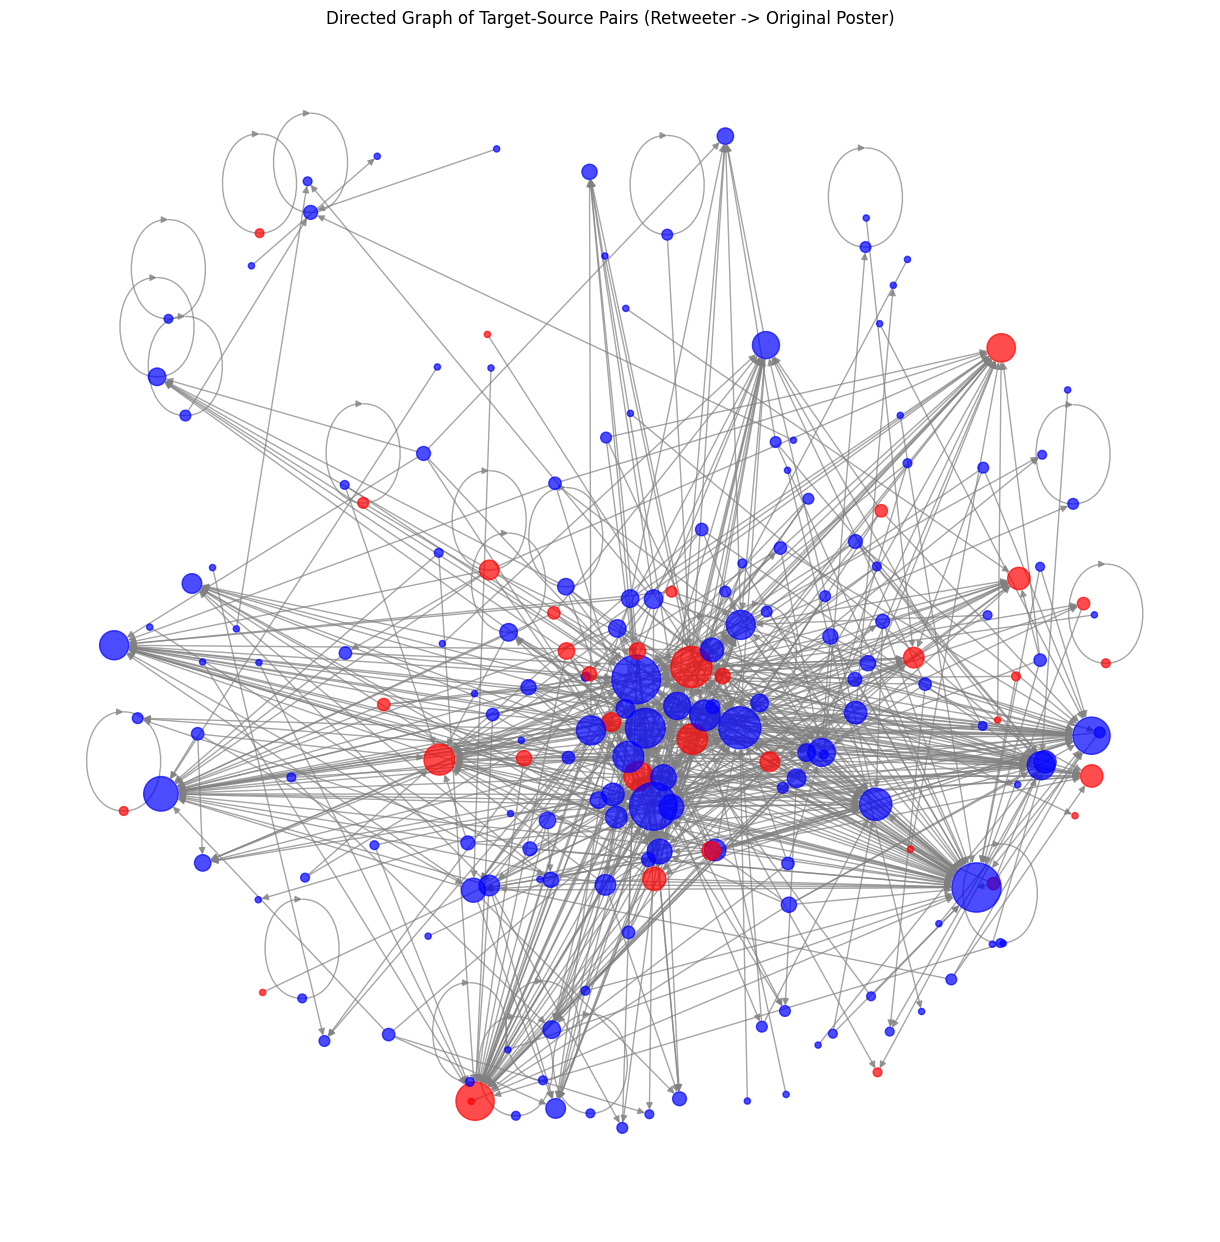

In [ ]:
G = nx.DiGraph()

for index, row in source_target_df.iterrows():
    source = row['source']  # Original poster
    target = row['target']  # Retweeter
    source_label = row['source_conspiracy_label']
    target_label = row['target_conspiracy_label']

    G.add_node(source, label=source_label)
    G.add_node(target, label=target_label)
    G.add_edge(target, source)

color_map = []
for node, data in G.nodes(data=True):
    if 'label' in data:
        color_map.append('red' if data['label'] == 1 else 'blue')  # Red for conspiracy (1), Blue for non-conspiracy (0)
    else:
        color_map.append('gray')

node_size = [20 * G.degree(node) for node in G.nodes()]
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)  # Position nodes using the spring layout
nx.draw(G, pos, with_labels=False, node_color=color_map, node_size=node_size, edge_color='gray', alpha=0.7, arrows=True)
plt.title("Directed Graph of Target-Source Pairs (Retweeter -> Original Poster)")
plt.show()


In [ ]:
# Export nodes file (unique nodes with labels)
nodes = pd.DataFrame({
    'id': list(G.nodes()),  # Unique node IDs (source and target)
    'label': list(G.nodes()),  # Same as the ID for simplicity
    'conspiracy_label': [G.nodes[node].get('label', None) for node in G.nodes()]  # Conspiracy label (0, 1, or None)
})
nodes.to_csv("gephi_nodes.csv", index=False)

edges = pd.DataFrame({
    'source': [edge[0] for edge in G.edges()],
    'target': [edge[1] for edge in G.edges()],
    'type': 'Directed',  # Gephi uses 'Directed' or 'Undirected' to specify edge direction
    'weight': 1 
})
edges.to_csv("gephi_edges.csv", index=False)
print("Nodes and edges exported for Gephi.")

Nodes and edges exported for Gephi.


In [ ]:
G = nx.DiGraph()
source_target_df = pd.DataFrame({
    'source': ['user1', 'user2'],
    'target': ['user3', 'user4'],
    'source_label': [1, 0],
    'target_label': [0, 1]
})

for index, row in source_target_df.iterrows():
    source = row['source']  # Original poster
    target = row['target']  # Retweeter
    source_label = row['source_label']
    target_label = row['target_label']

    G.add_node(source, label=source_label)
    G.add_node(target, label=target_label)
    G.add_edge(target, source)

edges_list = []
for source, target in G.edges():
    source_data = G.nodes[source]
    target_data = G.nodes[target]
    edges_list.append({
        'source': source,
        'target': target,
        'source_label': source_data['label'],
        'target_label': target_data['label']
    })

edges_df = pd.DataFrame(edges_list)
edges_df.to_csv('combined_edges.csv', index=False)
print("Combined edges file saved as 'combined_edges.csv'")

Combined edges file saved as 'combined_edges.csv'


In [ ]:
file_path = 'source_target_pairs_with_source_target_labels.csv'
source_target_df = pd.read_csv(file_path)

source_target_df
G = nx.DiGraph()
for _, row in source_target_df.iterrows():
    source = row['source']
    target = row['target']
    source_label = row['source_conspiracy_label']
    target_label = row['target_conspiracy_label']
    G.add_node(source, label=source_label)
    G.add_node(target, label=target_label)
    G.add_edge(source, target)

degree_centrality = nx.degree_centrality(G)
node_conspiracy_neighbors = {
    node: sum(G.nodes[neighbor]['label'] for neighbor in G.neighbors(node))
    for node in G.nodes
}
node_non_conspiracy_neighbors = {
    node: len(list(G.neighbors(node))) - node_conspiracy_neighbors[node]
    for node in G.nodes
}

# Identify communities
communities = list(greedy_modularity_communities(G))
community_data = {
    "community_id": [],
    "size": [],
    "conspiracy_percentage": []
}

for i, community in enumerate(communities):
    conspiracy_count = sum(G.nodes[node]['label'] for node in community)
    size = len(community)
    conspiracy_percentage = (conspiracy_count / size) * 100

    community_data["community_id"].append(i)
    community_data["size"].append(size)
    community_data["conspiracy_percentage"].append(conspiracy_percentage)

# Filter for the top 10 dominant communities
dominant_communities_df = pd.DataFrame(community_data).nlargest(10, 'size')

# Compile the results
central_nodes_info = {
    "node": [],
    "degree_centrality": [],
    "conspiracy_neighbors": [],
    "non_conspiracy_neighbors": []
}

top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10]

for node in top_nodes:
    central_nodes_info["node"].append(node)
    central_nodes_info["degree_centrality"].append(degree_centrality[node])
    central_nodes_info["conspiracy_neighbors"].append(node_conspiracy_neighbors[node])
    central_nodes_info["non_conspiracy_neighbors"].append(node_non_conspiracy_neighbors[node])

central_nodes_df = pd.DataFrame(central_nodes_info)
central_nodes_df, dominant_communities_df

(           node  degree_centrality  conspiracy_neighbors  \
 0  1.229369e+18           0.324742                   NaN   
 1  1.084023e+18           0.319588                   NaN   
 2  1.236755e+18           0.304124                   NaN   
 3  1.169671e+18           0.237113                   NaN   
 4  1.148461e+18           0.226804                   NaN   
 5  1.726487e+08           0.211340                   7.0   
 6  3.372975e+08           0.195876                   NaN   
 7  1.273277e+18           0.185567                   NaN   
 8  1.235320e+18           0.159794                   NaN   
 9  1.247260e+18           0.139175                   NaN   
 
    non_conspiracy_neighbors  
 0                       NaN  
 1                       NaN  
 2                       NaN  
 3                       NaN  
 4                       NaN  
 5                      14.0  
 6                       NaN  
 7                       NaN  
 8                       NaN  
 9               

In [11]:
# Load the data and create the graph:
file_path = 'source_target_pairs_with_source_target_labels.csv'
source_target_df = pd.read_csv(file_path)

G = nx.DiGraph()
for index, row in source_target_df.iterrows():
    G.add_node(row['source'], label=row['source_conspiracy_label'])
    G.add_node(row['target'], label=row['target_conspiracy_label'])
    G.add_edge(row['source'], row['target'])

# Degree :
degree_centrality = nx.degree_centrality(G)

# Conspiracy and non-conspiracy neighbors:
node_conspiracy_neighbors = {}
node_non_conspiracy_neighbors = {}

for node in G.nodes:
    neighbors = list(G.neighbors(node))
    conspiracy_count = sum(1 for neighbor in neighbors if G.nodes[neighbor]['label'] == 1)
    non_conspiracy_count = len(neighbors) - conspiracy_count

    node_conspiracy_neighbors[node] = conspiracy_count
    node_non_conspiracy_neighbors[node] = non_conspiracy_count


In [12]:
df = source_target_df

G = nx.DiGraph()

for _, row in df.iterrows():
    G.add_node(row['source'], label=row['source_conspiracy_label'])
    G.add_node(row['target'], label=row['target_conspiracy_label'])
    G.add_edge(row['source'], row['target'])

for node in G.nodes(data=True):
    print(node)

(18113993.0, {'label': 0.0})
(379366085.0, {'label': 0.0})
(1.1484612605157417e+18, {'label': 1.0})
(1.111868171965866e+18, {'label': 0.0})
(2679463669.0, {'label': 0.0})
(1.2351841613019013e+18, {'label': 0.0})
(1.0840226697234719e+18, {'label': 0.0})
(1.3125378774531195e+18, {'label': nan})
(44556034.0, {'label': 0.0})
(2260323354.0, {'label': nan})
(2981992586.0, {'label': 0.0})
(1.0804726816848445e+18, {'label': 0.0})
(1.11016939335757e+18, {'label': 1.0})
(1439362140.0, {'label': 0.0})
(1.2394254394850386e+18, {'label': 1.0})
(1.3967180025743483e+18, {'label': 0.0})
(19870712.0, {'label': 0.0})
(49014545.0, {'label': 0.0})
(1.0568588443102372e+18, {'label': 0.0})
(64274335.0, {'label': 0.0})
(1.2304732783823176e+18, {'label': 1.0})
(8.999306685908705e+17, {'label': 0.0})
(3035153498.0, {'label': 0.0})
(3268453153.0, {'label': 0.0})
(34300021.0, {'label': 0.0})
(1.254170178281255e+18, {'label': 0.0})
(91371789.0, {'label': 1.0})
(1.292094705845637e+18, {'label': 0.0})
(150350815.0,

In [ ]:
def generate_compact_node_report(G, node):
    d ={}

    if node not in G:
        return f"Node ID {node} does not exist in the graph."

    degree = G.degree(node)
    if degree == 0:
        return f"Node ID {node} has no connections."

   # Calculating metrics
    degree = G.degree(node)
    out_degree = G.out_degree(node)
    in_degree = G.in_degree(node)
    closeness = nx.closeness_centrality(G, node)
    # betweenness = nx.betweenness_centrality(G, node, normalized=True)
    clustering = nx.clustering(G, node)

    # Determining label classification
    # Counting conspiracy and non-conspiracy neighbors
    conspiracy_neighbors = sum(1 for neighbor in G.neighbors(node) if G.nodes[neighbor]['label'] == 1)
    non_conspiracy_neighbors = sum(1 for neighbor in G.neighbors(node) if G.nodes[neighbor]['label'] == 0)


    # Constructing the report
    # report = (
    #     f"Node ID {node} has a total degree of {degree}, out-degree of {out_degree}, and in-degree of {in_degree}. "
    #     f"Closeness centrality is {closeness:.4f} and clustering coefficient is {clustering:.4f}. "
    #     f"It has {conspiracy_neighbors} conspiracy spreader neighbors and {non_conspiracy_neighbors} non-conspiracy spreader neighbors. "
    # )

    report = (
        f"קודקוד מספר {node} בעל דרגה כוללת של {degree}, דרגת יציאה של {out_degree}, ודרגת כניסה של {in_degree}. "
        f"מדד הקרבה הוא {closeness:.4f} ומקדם ההתקבצות הוא {clustering:.4f}. "
        f"יש לו {conspiracy_neighbors} שכנים המפיצים תאוריות קונספירציה ו-{non_conspiracy_neighbors} שכנים שאינם מפיצים תאוריות קונספירציה. "
    )


    return report


# Creating a dictionary

In [14]:
user_id_data_dic = {}

for node in G.nodes():
  user_id_data_dic[node] = (generate_compact_node_report(G, node), [])

In [15]:
node_reports = [generate_compact_node_report(G, node) for node in G.nodes()]
for report in node_reports:
    print(report)

קודקוד מספר 18113993.0 בעל דרגה כוללת של 22, דרגת יציאה של 15, ודרגת כניסה של 7. מדד הקרבה הוא 0.0622 ומקדם ההתקבצות הוא 0.1082. יש לו 3 שכנים המפיצים תאוריות קונספירציה ו-10 שכנים שאינם מפיצים תאוריות קונספירציה. 
קודקוד מספר 379366085.0 בעל דרגה כוללת של 13, דרגת יציאה של 0, ודרגת כניסה של 13. מדד הקרבה הוא 0.1263 ומקדם ההתקבצות הוא 0.1603. יש לו 0 שכנים המפיצים תאוריות קונספירציה ו-0 שכנים שאינם מפיצים תאוריות קונספירציה. 
קודקוד מספר 1.1484612605157417e+18 בעל דרגה כוללת של 44, דרגת יציאה של 29, ודרגת כניסה של 15. מדד הקרבה הוא 0.1035 ומקדם ההתקבצות הוא 0.0926. יש לו 7 שכנים המפיצים תאוריות קונספירציה ו-19 שכנים שאינם מפיצים תאוריות קונספירציה. 
קודקוד מספר 1.111868171965866e+18 בעל דרגה כוללת של 8, דרגת יציאה של 7, ודרגת כניסה של 1. מדד הקרבה הוא 0.0506 ומקדם ההתקבצות הוא 0.1071. יש לו 2 שכנים המפיצים תאוריות קונספירציה ו-5 שכנים שאינם מפיצים תאוריות קונספירציה. 
קודקוד מספר 2679463669.0 בעל דרגה כוללת של 2, דרגת יציאה של 0, ודרגת כניסה של 2. מדד הקרבה הוא 0.0797 ומקדם ההתקבצות הו

In [16]:
len(user_id_data_dic)

195

In [17]:
user_id_data_dic[463393342]

('קודקוד מספר 463393342.0 בעל דרגה כוללת של 3, דרגת יציאה של 1, ודרגת כניסה של 2. מדד הקרבה הוא 0.0683 ומקדם ההתקבצות הוא 0.3333. יש לו 0 שכנים המפיצים תאוריות קונספירציה ו-1 שכנים שאינם מפיצים תאוריות קונספירציה. ',
 [])

In [18]:
df = pd.read_csv('data_with_tweetid.csv', encoding='utf-8-sig')

for index, row in df.iterrows():

    user_id = row['uid']
    tweet_id = row['most_similar_tweet_id']
    tweet_class = row['conspiracy']
    tweet_text = row['tweet_text']

    if user_id not in user_id_data_dic:
        user_id_data_dic[user_id] = (generate_compact_node_report(G, user_id), [])

    elif user_id in user_id_data_dic:
        user_id_data_dic[user_id][1].append((tweet_id, tweet_class, tweet_text))

In [19]:
print(user_id_data_dic)

{18113993.0: ('קודקוד מספר 18113993.0 בעל דרגה כוללת של 22, דרגת יציאה של 15, ודרגת כניסה של 7. מדד הקרבה הוא 0.0622 ומקדם ההתקבצות הוא 0.1082. יש לו 3 שכנים המפיצים תאוריות קונספירציה ו-10 שכנים שאינם מפיצים תאוריות קונספירציה. ', [(1371801157597859849, 0, 'אבי רבינא: ברגע האחרון נתניהו ביטל את הגעתו לכנס בחירות הערב באשקלון. לשכת רה"מ: "סיבות שאי אפשר לפרט" .  נפרט בכל זאת: האולם היה ריק...'), (1378780177749184512, 0, 'בהרבה מסעדות בתל אביב מבקשים את זה'), (1373184409847930883, 0, 'נכון. אצלנו יותר חשוב להסתיר לטייח ולמכור שקרים.'), (1354891772778999808, 1, 'עמוד ראשי באתר חדשות. ישראלי ממוצע גולל וקורא שמתכננים לקחת לו את פורים, הוא יידרש לעטות שתי (!) מסיכות, ושהחיסון שעד לפני שבוע נדחף בכח להריוניות, כעת מוגדר כמסוכן לחלקן. ומה עושה הישראלי המצוי נוכח בליץ החורבן הזה? מקשקש בזנבו, מלקק לעצמו את הביצים ויושב לצפות בנינג׳ה ישראל.'), (1405058011761102850, 0, 'שמעתי שזה קורה גם בפרדס חנה כרכור. #זהממשנורא')]), 379366085.0: ('קודקוד מספר 379366085.0 בעל דרגה כוללת של 13, דרגת יציאה של 

In [20]:
print(len(user_id_data_dic))

1087


In [21]:
user_id_data_dic[18113993.0]

('קודקוד מספר 18113993.0 בעל דרגה כוללת של 22, דרגת יציאה של 15, ודרגת כניסה של 7. מדד הקרבה הוא 0.0622 ומקדם ההתקבצות הוא 0.1082. יש לו 3 שכנים המפיצים תאוריות קונספירציה ו-10 שכנים שאינם מפיצים תאוריות קונספירציה. ',
 [(1371801157597859849,
   0,
   'אבי רבינא: ברגע האחרון נתניהו ביטל את הגעתו לכנס בחירות הערב באשקלון. לשכת רה"מ: "סיבות שאי אפשר לפרט" .  נפרט בכל זאת: האולם היה ריק...'),
  (1378780177749184512, 0, 'בהרבה מסעדות בתל אביב מבקשים את זה'),
  (1373184409847930883, 0, 'נכון. אצלנו יותר חשוב להסתיר לטייח ולמכור שקרים.'),
  (1354891772778999808,
   1,
   'עמוד ראשי באתר חדשות. ישראלי ממוצע גולל וקורא שמתכננים לקחת לו את פורים, הוא יידרש לעטות שתי (!) מסיכות, ושהחיסון שעד לפני שבוע נדחף בכח להריוניות, כעת מוגדר כמסוכן לחלקן. ומה עושה הישראלי המצוי נוכח בליץ החורבן הזה? מקשקש בזנבו, מלקק לעצמו את הביצים ויושב לצפות בנינג׳ה ישראל.'),
  (1405058011761102850, 0, 'שמעתי שזה קורה גם בפרדס חנה כרכור. #זהממשנורא')])

# DictaLM 0.2

In [22]:
from transformers import pipeline
import torch

In [23]:
# Load the Hugging Face Dicta2 model
classifier = pipeline("text-classification", model="dicta-il/dictalm2.0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictalm2.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/932 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/513k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.86M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Device set to use cuda:0


In [24]:
# List of different prompts for comparison
prompts = [
    "האם הציוץ הזה מפיץ תאוריית קונספירציה? הסבר את ההגיון שלך."
]

In [27]:
few_shot_examples = [
    "שרשור מרתק על איך התחילה שגעת הונאת הקורונה, שלב אחרי שלב",
    "אני לא חשוב ולא מעניין. תתייחס למאמר של איתי רום ותביע את דעתך בנוגע אליו ובכל הקשור להסתרת מידע על אינטרסים וכספים והקשר בין חברות תרופות לבין רופאים ואנשים בתפקידים בכירים ששולטים על חיינו.",
    "גבר בן 90 עם 80 מחלות רקע מתאשפז בפעם החמישית בחודש ונפטר= מת מקורונה.  אישה הריונית צעירה מתמוטטת בביתה ומתה כעבור כמה שעות בפתאומיות, יחד עם עוברה, חודש לאחר שחוסנה= אין קשר לחיסון.  הבנתי נכון?",
    "שרשור פנטסטי על דינגיות, מיוקרדיטיס וקורונה (כן כן, שוב).",
    "מוזר שישראל, מדינת ההיטק עדיין בוחרת בקלפיות כמו מדינת עולם שלישי ולא כמו מדינות אירופה, ארה״ב, קנדה ואפילו רוב מדינות אמריקה הלטינית",
    "@guylerer אותי יותר מטריד שלאחת כמוה יש בן זוג ואני עדיין רווקה"
]

few_shot_prompt = (
    "הנה כמה דוגמאות לציוצים קונספירטיביים:\n"
    f"{few_shot_examples[0]}\n"
    f"{few_shot_examples[1]}\n"
    f"{few_shot_examples[2]}\n"
    "הנה כמה דוגמאות לציוצים שאינם קונספירטיביים:\n"
    f"{few_shot_examples[3]}\n"
    f"{few_shot_examples[4]}\n"
    f"{few_shot_examples[5]}\n"
)

In [28]:
# Store results using DataFrame
results_df = pd.DataFrame(columns=['user_id', 'tweet_id', 'tweet_class', 'tweet', 'prompt',
                                   'response_only_tweet', 'response_only_tweet_certainty',
                                   'response_with_network', 'response_with_network_certainty',
                                   'response_few_shot_tweet', 'response_few_shot_tweet_certainty',
                                   'response_few_shot_network', 'response_few_shot_network_certainty'])

In [29]:
# Loop through nodes and send multiple prompts to the Hugging Face Dicta2 model:
for user_id, (description, tweets) in user_id_data_dic.items():
    for tweet_info in tweets:
        tweet_id, tweet_class, tweet = tweet_info
        for prompt in prompts:

            only_tweet = f"בהינתן הציוץ הבא: '{tweet}'. \n{prompt}"
            full_prompt = f"בהתבסס על מבנה הרשת: {description} \n והציוץ הבא של המשתמש: '{tweet}'.\n{prompt}"
            few_shot_tweet = f"{few_shot_prompt}\n בהינתן הציוץ הבא'{tweet}'."
            few_shot_full = f"{few_shot_prompt}\n בהתבסס על מבנה הרשת: {description}\n והציוץ הבא של המשתמש: '{tweet}'."

            response = classifier(only_tweet)
            full_response = classifier(full_prompt)
            few_shot_response = classifier(few_shot_tweet)
            few_shot_network_response = classifier(few_shot_full)

            results_df = pd.concat([results_df, pd.DataFrame({
            'user_id': user_id,
            'tweet_id': tweet_id,
            'tweet_class': tweet_class,
            'tweet': tweet,
            'prompt': prompt,
            'response_only_tweet': [response[0]['label']],
            'response_only_tweet_certainty': [response[0]['score']],
            'response_with_network': [full_response[0]['label']],
            'response_with_network_certainty': [full_response[0]['score']],
            'response_few_shot_tweet': [few_shot_response[0]['label']],
            'response_few_shot_tweet_certainty': [few_shot_response[0]['score']],
            'response_few_shot_network': [few_shot_network_response[0]['label']],
            'response_few_shot_network_certainty': [few_shot_network_response[0]['score']]
        })], ignore_index=True)

<ipython-input-29-ae0d9e62fa3e>:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


In [43]:
columns_to_convert = ['response_only_tweet', 'response_with_network', 'response_few_shot_tweet', 'response_few_shot_network']
results_df[columns_to_convert] = results_df[columns_to_convert].replace({'LABEL_1': 1, 'LABEL_0': 0})

<ipython-input-43-d53dfbc4e2b0>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df[columns_to_convert] = results_df[columns_to_convert].replace({'LABEL_1': 1, 'LABEL_0': 0})


In [44]:
# Save results to CSV
results_df.to_csv('dicta2_combined_classification_results.csv', index=False, encoding='utf-8-sig')

print("Results including few-shot learning and network-based prompts saved successfully to 'dicta2_combined_classification_results.csv'.")

Results including few-shot learning and network-based prompts saved successfully to 'dicta2_combined_classification_results.csv'.


**Evaluation**

In [31]:
# results_df = pd.read_csv('dicta2_classification_results.csv') # to avoid running the DictaLM model again

In [32]:
print(results_df['response_only_tweet'].value_counts())

response_only_tweet
LABEL_0    1688
LABEL_1    1386
Name: count, dtype: int64


In [33]:
print(results_df['response_with_network'].value_counts())

response_with_network
LABEL_0    2598
LABEL_1     476
Name: count, dtype: int64


In [34]:
print(results_df['response_few_shot_tweet'].value_counts())

response_few_shot_tweet
LABEL_0    1666
LABEL_1    1408
Name: count, dtype: int64


In [35]:
print(results_df['response_few_shot_network'].value_counts())

response_few_shot_network
LABEL_1    2895
LABEL_0     179
Name: count, dtype: int64


In [36]:
changed_decision = results_df[results_df['response_only_tweet'] != results_df['response_with_network']]

print(f"{len(changed_decision)} instances where the model changed its decision:")

changed_decision[['user_id', 'tweet', 'response_only_tweet', 'response_with_network']]

1306 instances where the model changed its decision:


,user_id,tweet,response_only_tweet,response_with_network
0,1.811399e+07,אבי רבינא: ברגע האחרון נתניהו ביטל את הגעתו לכ...,LABEL_1,LABEL_0
1,1.811399e+07,בהרבה מסעדות בתל אביב מבקשים את זה,LABEL_0,LABEL_1
6,3.793661e+08,הסנקציות על סרבני חיסון | במשרד הבריאות מגבשים...,LABEL_1,LABEL_0
7,3.793661e+08,זה הכי קל בארץ 1. ביבי חייב למנוע תמיכה של רעם...,LABEL_1,LABEL_0
8,3.793661e+08,"כמה עשרות בני אדם מפגינים מול הכנסת, שם מתקיים...",LABEL_1,LABEL_0
...,...,...,...,...
3062,2.653397e+09,נראה לי שבמצבנו היום עדיף להפסיק לנסות דו קיום...,LABEL_1,LABEL_0
3063,2.653397e+09,"רק הסתה מגיעה ממך, כל הזמן לזרוע רעל ואחרי להא...",LABEL_1,LABEL_0
3065,1.555732e+08,This is Haaretz today. The children Israel kil...,LABEL_1,LABEL_0
3068,1.396671e+08,כמה מסית ומפלג נתניהו #3 עדיף למות מאשר לחיות ...,LABEL_1,LABEL_0


In [37]:
changed_decision = results_df[results_df['response_few_shot_tweet'] != results_df['response_few_shot_network']]

print(f"{len(changed_decision)} instances where the model changed its decision:")

changed_decision[['user_id', 'tweet', 'response_few_shot_tweet', 'response_few_shot_network']]

1531 instances where the model changed its decision:


,user_id,tweet,response_few_shot_tweet,response_few_shot_network
0,1.811399e+07,אבי רבינא: ברגע האחרון נתניהו ביטל את הגעתו לכ...,LABEL_0,LABEL_1
1,1.811399e+07,בהרבה מסעדות בתל אביב מבקשים את זה,LABEL_0,LABEL_1
5,3.793661e+08,דיקטטור הקורונה,LABEL_0,LABEL_1
6,3.793661e+08,הסנקציות על סרבני חיסון | במשרד הבריאות מגבשים...,LABEL_0,LABEL_1
9,3.793661e+08,לנתניהו אין סמכות להבעיר מיכליות אירניות בכדי ...,LABEL_0,LABEL_1
...,...,...,...,...
3063,2.653397e+09,"רק הסתה מגיעה ממך, כל הזמן לזרוע רעל ואחרי להא...",LABEL_0,LABEL_1
3064,2.379080e+08,"לא נכון, גם בקליפורניה, ואפילו מסכה כפולה אם אפשר",LABEL_0,LABEL_1
3066,1.551521e+09,טמבל מי שהמליט אותך. הלוואי שהילדים שלך ירכבו ...,LABEL_0,LABEL_1
3070,1.298591e+08,מה עם אוחנה הזבל? מתי הוא מתכוון להתפטר בעקבו...,LABEL_0,LABEL_1


Evaluating model performance based on ground truth labels...

Evaluation for: response_only_tweet
              precision    recall  f1-score   support

           0       0.84      0.57      0.68      2485
           1       0.23      0.53      0.32       589

    accuracy                           0.56      3074
   macro avg       0.53      0.55      0.50      3074
weighted avg       0.72      0.56      0.61      3074



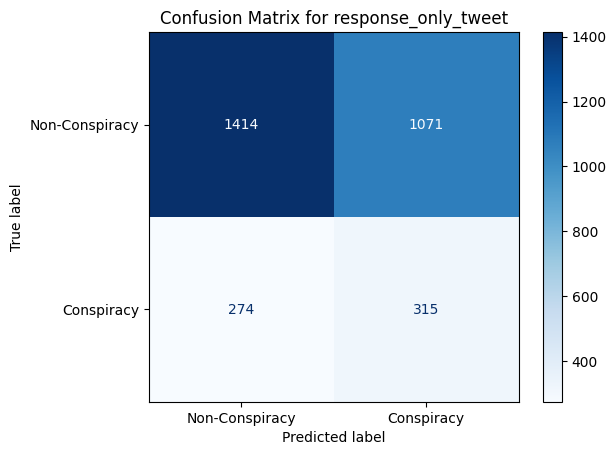


Evaluation for: response_with_network
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      2485
           1       0.29      0.23      0.26       589

    accuracy                           0.74      3074
   macro avg       0.56      0.55      0.55      3074
weighted avg       0.72      0.74      0.73      3074



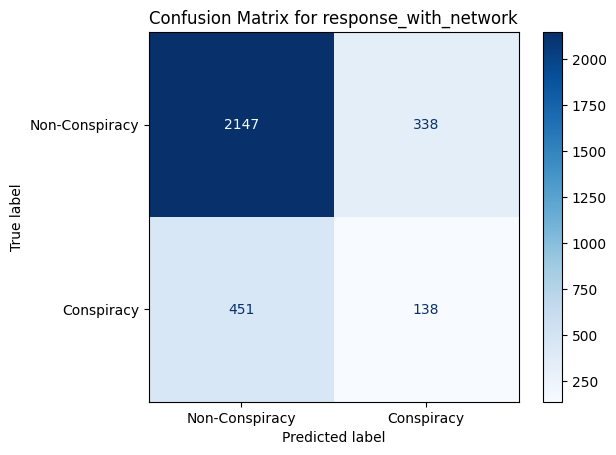


Evaluation for: response_few_shot_tweet
              precision    recall  f1-score   support

           0       0.79      0.53      0.64      2485
           1       0.17      0.42      0.25       589

    accuracy                           0.51      3074
   macro avg       0.48      0.48      0.44      3074
weighted avg       0.68      0.51      0.56      3074



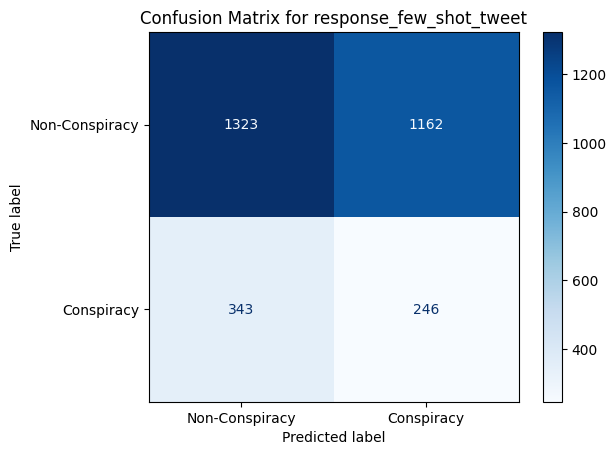


Evaluation for: response_few_shot_network
              precision    recall  f1-score   support

           0       0.89      0.06      0.12      2485
           1       0.20      0.97      0.33       589

    accuracy                           0.24      3074
   macro avg       0.55      0.52      0.22      3074
weighted avg       0.76      0.24      0.16      3074



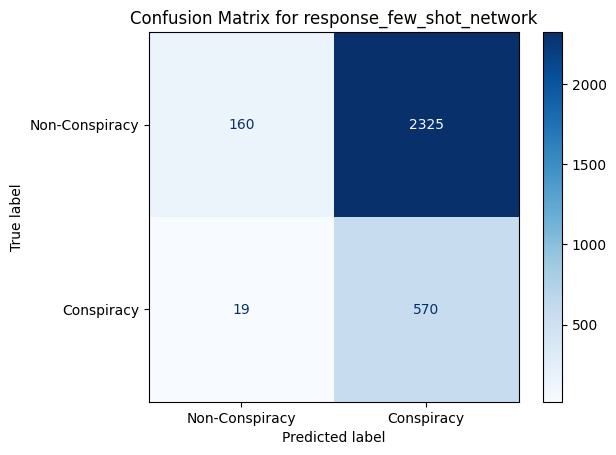

Results including evaluations saved successfully.


In [45]:
# Evaluation Section
print("Evaluating model performance based on ground truth labels...")
y_true = results_df['tweet_class'].astype(int)

# Evaluate for each classification method
def evaluate_performance(column_name):
    y_pred = results_df[column_name].astype(int)
    print(f"\nEvaluation for: {column_name}")
    print(classification_report(y_true, y_pred))
    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Conspiracy', 'Conspiracy'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {column_name}')
    plt.show()

# Run evaluation for all classifiers
evaluate_performance('response_only_tweet')
evaluate_performance('response_with_network')
evaluate_performance('response_few_shot_tweet')
evaluate_performance('response_few_shot_network')

print("Results including evaluations saved successfully.")